# Exploring Relationship of time and prices
In this Notebook we look into the hype of cryptopunks beginning in July / August 2020. 

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/kalinakalina/DEDA_Cryptopunks/main/transaction.csv', header = None, index_col = 0)
df.columns = ['type', 'from', 'to', 'date', 'punk_id', 'amount_in_eth', 'amount_in_dol']
df = df[ ['punk_id'] + [ col for col in df.columns if col != 'punk_id' ] ]

In [ ]:
df['punk_id'] = df['punk_id'].astype('category')
df['type'] = df['type'].astype('category')
df['from'] = df['from'].astype(str)
df['to'] = df['to'].astype(str)
df['date'] = pd.to_datetime(df['date'], format = '%Y.%m.%d')

In [ ]:
#Fix amount values in eth and dollar
df['amount_in_eth'] = df['amount_in_eth'].astype(str)
df['amount_in_eth'] = df['amount_in_eth'].str.replace('Y', '')
df['amount_in_eth'] = df['amount_in_eth'].str.replace('Z', '')
df['amount_in_eth'] = df['amount_in_eth'].str.replace('M', '')
df['amount_in_eth'] = df['amount_in_eth'].str.replace('T', '')
df['amount_in_eth'] = df['amount_in_eth'].str.replace('B', '')
df['amount_in_eth'] = df['amount_in_eth'].replace(',', '', regex=True)
df['amount_in_eth'] = df['amount_in_eth'].astype(float)

df['amount_in_dol'] = df['amount_in_dol'].astype(str)
df['amount_in_dol'] = df['amount_in_dol'].str.replace('Y', '')
df['amount_in_dol'] = df['amount_in_dol'].str.replace('B', '')
df['amount_in_dol'] = df['amount_in_dol'].str.replace('T', '')
df['amount_in_dol'] = df['amount_in_dol'].str.replace('P', '')
df['amount_in_dol'] = df['amount_in_dol'].str.replace('Z', '')
df['amount_in_dol'] = df['amount_in_dol'].replace('<', '', regex=True)
df['amount_in_dol'] = df['amount_in_dol'].replace(',', '', regex=True)
df['amount_in_dol'] = df['amount_in_dol'].astype(float)

In [ ]:
df['amount_in_eth'] = df['amount_in_eth'].fillna(0)
df['amount_in_dol'] = df['amount_in_dol'].fillna(0)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 115734 entries, 0 to 49
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   punk_id        115734 non-null  category      
 1   type           115734 non-null  category      
 2   from           115734 non-null  object        
 3   to             115734 non-null  object        
 4   date           115734 non-null  datetime64[ns]
 5   amount_in_eth  115734 non-null  float64       
 6   amount_in_dol  115734 non-null  float64       
dtypes: category(2), datetime64[ns](1), float64(2), object(2)
memory usage: 6.0+ MB


In [ ]:
df.head()

,punk_id,type,from,to,date,amount_in_eth,amount_in_dol
0,,,,,,,
0,0,Bid Withdrawn,0x983ace,nan,2021-05-10,250.0,1030000.0
1,0,Bid,0x983ace,nan,2021-04-11,250.0,537615.0
2,0,Bid Withdrawn,0xd7510a,nan,2021-03-03,100.0,160973.0
3,0,Bid,0xd7510a,nan,2021-02-20,100.0,188897.0
4,0,Bid Withdrawn,natealex,nan,2020-09-16,69.0,25532.0


# Dates

In [ ]:
df.head()

,punk_id,type,from,to,date,amount_in_eth,amount_in_dol
0,,,,,,,
0,0,Bid Withdrawn,0x983ace,nan,2021-05-10,250.0,1030000.0
1,0,Bid,0x983ace,nan,2021-04-11,250.0,537615.0
2,0,Bid Withdrawn,0xd7510a,nan,2021-03-03,100.0,160973.0
3,0,Bid,0xd7510a,nan,2021-02-20,100.0,188897.0
4,0,Bid Withdrawn,natealex,nan,2020-09-16,69.0,25532.0


In [ ]:
date_df = df.groupby(['date', 'type']).size().reset_index().pivot(columns='type', index='date', values=0)

#Join aggregate sales
agg_sales = df.assign(
 sales_in_eth = np.where(df['type']=='Sold',df.amount_in_eth, 0)
 ).groupby('date').agg({'sales_in_eth':sum})
date_df = agg_sales.merge(date_df, how='inner', left_index=True, right_index=True)

#Join aggregate bids
agg_bids = df.assign(
 bids_in_eth = np.where(df['type']=='Bid',df.amount_in_eth, 0)
 ).groupby('date').agg({'bids_in_eth':sum})
date_df = date_df.join(agg_bids, on=date_df.index, how='left', lsuffix='_', rsuffix='_')

date_df

,sales_in_eth,(Unwrap),(Wrap),Bid,Bid Withdrawn,Claimed,Offer Withdrawn,Offered,Sold,Transfer,bids_in_eth
date,,,,,,,,,,,
2017-06-23,3.09,0,0,32,2,10000,0,39,20,2,5.77
2017-06-24,4.27,0,0,26,6,0,15,240,22,6,4.51
2017-06-25,1.80,0,0,685,206,0,0,104,13,5,44.15
2017-06-26,2.44,0,0,1020,17,0,7,41,18,56,68.90
2017-06-27,8.00,0,0,113,5,0,4,32,36,1,29.73
...,...,...,...,...,...,...,...,...,...,...,...
2021-05-12,708.22,12,28,39,28,0,35,257,30,35,696.74
2021-05-13,868.23,16,12,94,58,0,21,239,50,16,1777.67
2021-05-14,620.28,4,4,62,34,0,11,124,26,46,1198.69


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fb08c746710>,
      dtype=object)

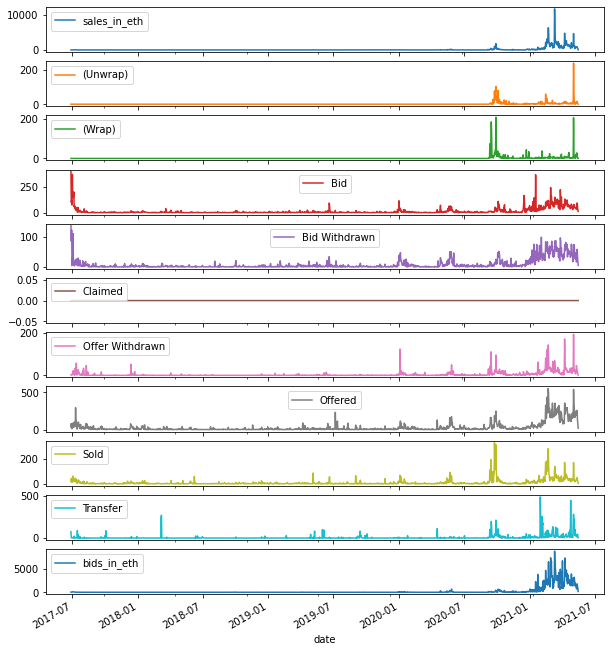

In [ ]:
mask = (date_df.index > '2017-06-27') & (date_df.index <= '2021-05-16')
new_date_df = date_df.loc[mask]
new_date_df.plot(subplots=True, figsize=(10,12))

<Figure size 720x432 with 0 Axes>

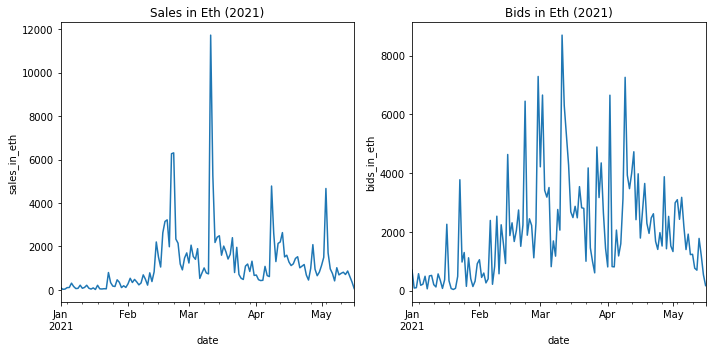

In [ ]:
plt.figure(1)
fig = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

ax1 = plt.subplot(121)
date_df['2021'].sales_in_eth.plot(ax=ax1, title = 'Sales in Eth (2021)')
plt.ylabel('sales_in_eth')

ax2 = plt.subplot(122)
date_df['2021'].bids_in_eth.plot(ax=ax2, title = 'Bids in Eth (2021)')
plt.ylabel('bids_in_eth')

plt.tight_layout()

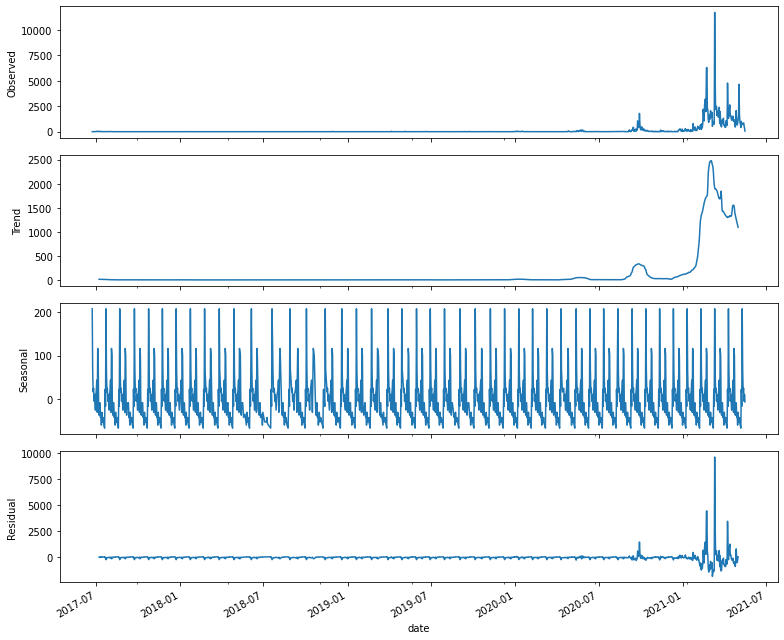

In [ ]:
from pylab import rcParams
import statsmodels.api as sm

rcParams['figure.figsize'] = 11, 9
mask = (date_df.index > '2020-06-27') & (date_df.index <= '2021-05-16')
new_date_df = date_df.loc[mask]
decomposition = sm.tsa.seasonal_decompose(date_df['sales_in_eth'],freq=30, model='M')
fig = decomposition.plot()
plt.show()

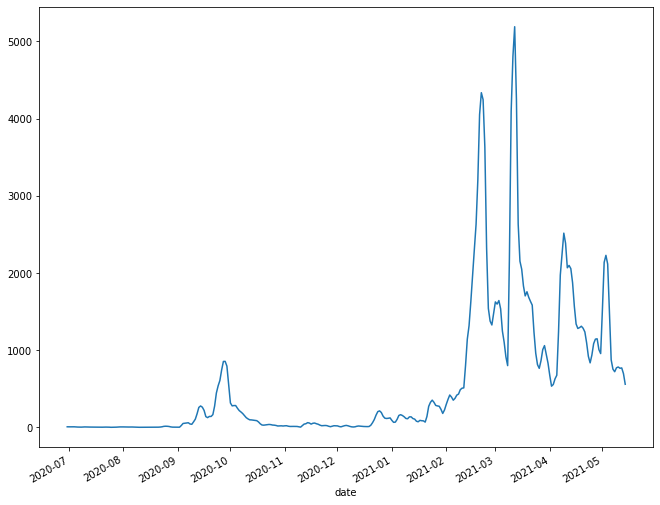

In [ ]:
mask = (date_df.index > '2020-06-27') & (date_df.index <= '2021-05-16')
new_date_df = date_df.loc[mask]
decomposition = sm.tsa.seasonal_decompose(new_date_df['sales_in_eth'],freq=4, model='M')
fig = decomposition.plot()
plt.show()
decomposition.trend.plot()
plt.show()

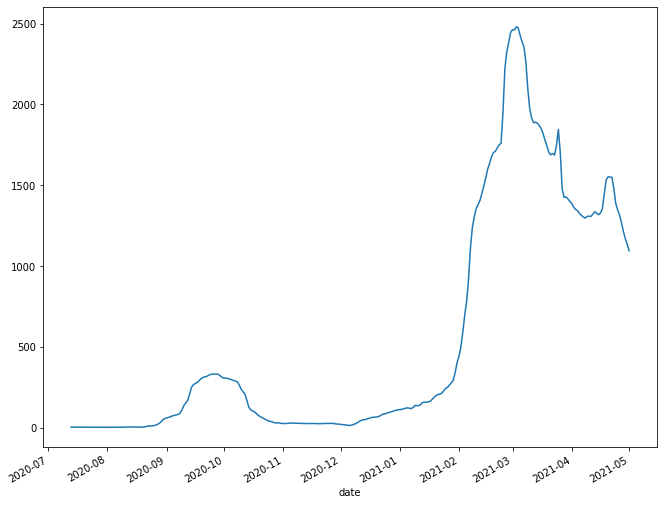

In [ ]:
mask = (date_df.index > '2020-06-27') & (date_df.index <= '2021-05-16')
new_date_df = date_df.loc[mask]
decomposition = sm.tsa.seasonal_decompose(new_date_df['sales_in_eth'],freq=30, model='M')

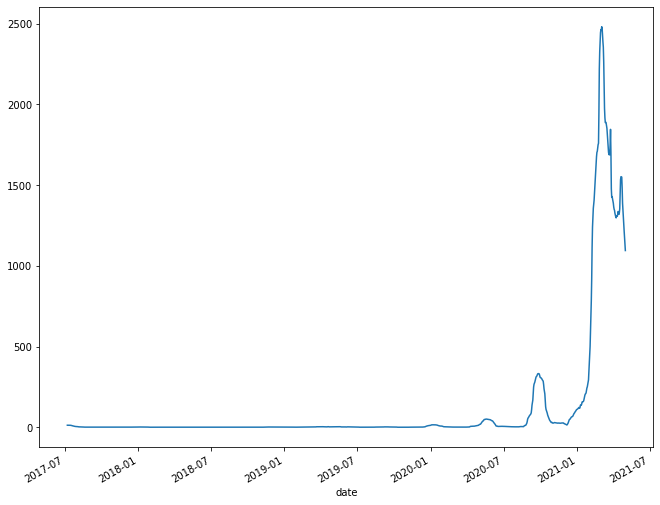

       sales_in_eth
count   1297.000000
mean     127.728163
std      416.439646
min        0.083833
25%        0.727667
50%        1.930000
75%       11.498333
max     2480.937833

middle section
            sales_in_eth
date                    
2017-08-02      4.291167
2017-08-03      3.794667
2017-08-04      3.344000
2017-08-05      3.020667
2017-08-06      2.831500
2017-08-07      2.776833
2017-08-08      2.681333
2017-08-09      2.463333
2017-08-10      2.307500
2017-08-11      2.290167


In [ ]:
decomposition.trend.plot()
plt.show()
trend = pd.DataFrame(decomposition.trend)
print(trend.describe())
print()
print('middle section')
print(trend.iloc[40:50])

       sales_in_eth
count    269.000000
mean       1.195001
std      783.009175
min    -2031.811922
25%     -294.503787
50%      -10.452826
75%      242.495040
max     7896.965001

middle section
            sales_in_eth
date                    
2020-08-07      4.981597
2020-08-08    273.247155
2020-08-09    245.595828
2020-08-10    143.449944
2020-08-12    239.563463
2020-08-13    257.702944
2020-08-14  -1944.687883
2020-08-15   -653.217249
2020-08-16     -7.599903
2020-08-17    -51.613249


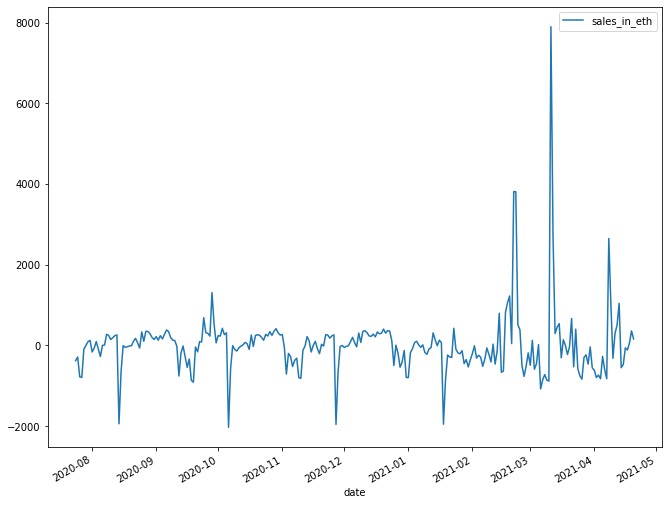

In [ ]:
resid = pd.DataFrame(decomposition.resid)
print(resid.describe())
print()
print('middle section')
print(resid.iloc[40:50])
resid.plot()
plt.show()